In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

In [ ]:
# Load datasets
customers = pd.read_csv("/content/drive/MyDrive/Zeotapfiles/Customers.csv")
transactions = pd.read_csv("/content/drive/MyDrive/Zeotapfiles/Transactions.csv")

In [ ]:
# Merge Customers and Transactions on CustomerID
merged_data = pd.merge(transactions, customers, on="CustomerID")


In [ ]:
# Create customer features
customer_features = merged_data.groupby("CustomerID").agg(
    TotalSpend=("TotalValue", "sum"),
    Frequency=("TransactionID", "count"),
    Recency=("TransactionDate", lambda x: (pd.to_datetime("2024-12-31") - pd.to_datetime(x.max())).days),
    Region=("Region", "first"),  # Region is the same for each customer
    SignupDate=("SignupDate", "first")  # SignupDate is the same for each customer
).reset_index()


In [ ]:
print(customer_features.columns)

Index(['CustomerID', 'TotalSpend', 'Frequency', 'Recency', 'Region',
       'SignupDate'],
      dtype='object')


In [ ]:
# Display customer features
print(customer_features.head())

  CustomerID  TotalSpend  Frequency  Recency         Region  SignupDate
0      C0001     3354.52          5       58  South America  2022-07-10
1      C0002     1862.74          4       27           Asia  2022-02-13
2      C0003     2725.38          4      128  South America  2024-03-07
3      C0004     5354.88          8        7  South America  2022-10-09
4      C0005     2034.24          3       56           Asia  2022-08-15


Step 2: Feature Engineering

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [ ]:
# Encode categorical variables (Region)
encoder = OneHotEncoder(sparse_output=False, drop="first")
encoded_features = encoder.fit_transform(customer_features[["Region"]])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(["Region"]))


In [ ]:
# Normalize numerical features (TotalSpend, Frequency, Recency)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features[["TotalSpend", "Frequency", "Recency"]])
scaled_df = pd.DataFrame(scaled_features, columns=["TotalSpend", "Frequency", "Recency"])


In [ ]:
# Combine encoded and scaled features
features = pd.concat([customer_features["CustomerID"], encoded_df, scaled_df], axis=1)


In [ ]:
# Display engineered features
print(features.head())

  CustomerID  Region_Europe  Region_North America  Region_South America  \
0      C0001            0.0                   0.0                   1.0   
1      C0002            0.0                   0.0                   0.0   
2      C0003            0.0                   0.0                   1.0   
3      C0004            0.0                   0.0                   1.0   
4      C0005            0.0                   0.0                   0.0   

   TotalSpend  Frequency   Recency  
0   -0.061701  -0.011458 -0.261180  
1   -0.877744  -0.467494 -0.699369  
2   -0.405857  -0.467494  0.728278  
3    1.032547   1.356650 -0.982071  
4   -0.783929  -0.923530 -0.289450  


Step 3: Clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score


In [ ]:
# Determine the optimal number of clusters using the Elbow Method
inertia = []
silhouette_scores = []
k_values = range(2, 11)

In [ ]:
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features.drop("CustomerID", axis=1))
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(features.drop("CustomerID", axis=1), kmeans.labels_))


Text(0.5, 1.0, 'Elbow Method')

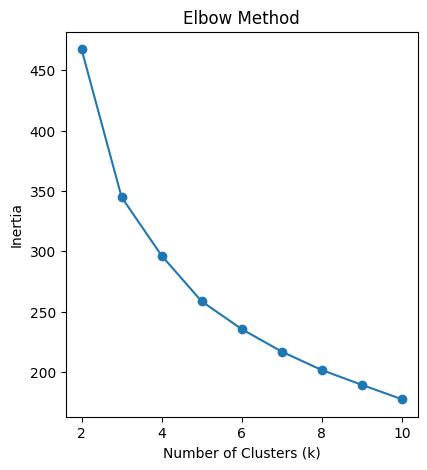

In [ ]:
# Plot Elbow Method
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method")


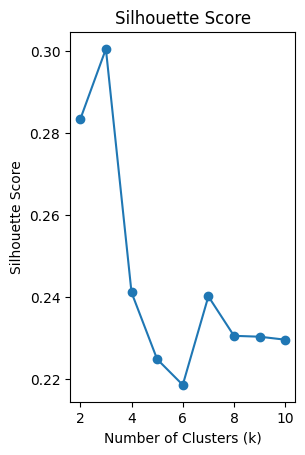

In [ ]:
# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score")
plt.show()

In [ ]:
# Choose the optimal number of clusters (e.g., k=4 based on the plots)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(features.drop("CustomerID", axis=1))

KMeans(n_clusters=4, random_state=42)

In [ ]:
# Add cluster labels to the features DataFrame
features["Cluster"] = kmeans.labels_

In [ ]:
# Display clusters
print(features.head())

  CustomerID  Region_Europe  Region_North America  Region_South America  \
0      C0001            0.0                   0.0                   1.0   
1      C0002            0.0                   0.0                   0.0   
2      C0003            0.0                   0.0                   1.0   
3      C0004            0.0                   0.0                   1.0   
4      C0005            0.0                   0.0                   0.0   

   TotalSpend  Frequency   Recency  Cluster  
0   -0.061701  -0.011458 -0.261180        3  
1   -0.877744  -0.467494 -0.699369        1  
2   -0.405857  -0.467494  0.728278        3  
3    1.032547   1.356650 -0.982071        0  
4   -0.783929  -0.923530 -0.289450        1  


Step 4: Evaluate Clusters

In [ ]:
# Calculate clustering metrics
db_index = davies_bouldin_score(features.drop("CustomerID", axis=1), kmeans.labels_)
silhouette_avg = silhouette_score(features.drop("CustomerID", axis=1), kmeans.labels_)


In [ ]:
print(f"Davies-Bouldin Index: {db_index}")
print(f"Silhouette Score: {silhouette_avg}")

Davies-Bouldin Index: 0.8617554390775476
Silhouette Score: 0.4343981670494767


In [ ]:
# Visualize clusters using PCA
from sklearn.decomposition import PCA

In [ ]:
# Apply PCA for 2D visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features.drop(["CustomerID", "Cluster"], axis=1))
pca_df = pd.DataFrame(pca_features, columns=["PC1", "PC2"])
pca_df["Cluster"] = features["Cluster"]


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

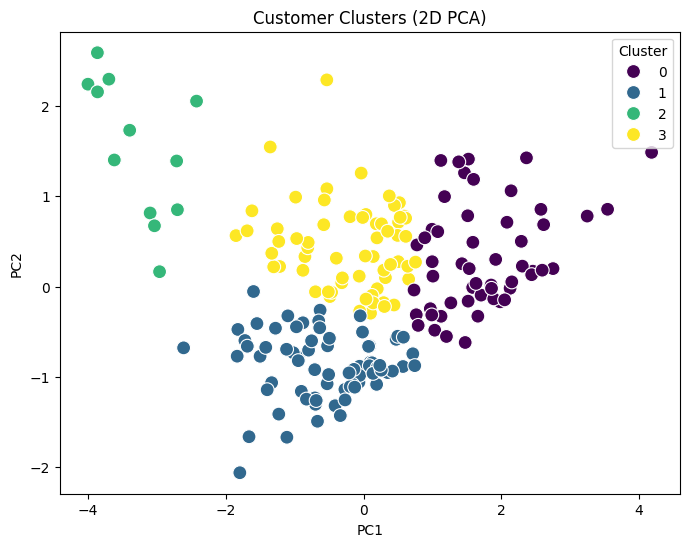

In [ ]:
# Plot clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Cluster", palette="viridis", s=100)
plt.title("Customer Clusters (2D PCA)")
plt.show()